In [7]:
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import callbacks
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout
from sklearn.model_selection import KFold
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,f1_score, precision_score, recall_score, accuracy_score

warnings.filterwarnings(action='ignore')
tf.config.set_visible_devices([], 'GPU')

In [8]:
df = pd.read_csv("data/modified_0420.csv")
x_train = df.drop(columns=['loan_status','Unnamed: 0'])
y_train = df['loan_status']

In [9]:
df['loan_status'].value_counts()

loan_status
0    902997
1    228685
Name: count, dtype: int64

In [10]:
nan_indices = np.isnan(x_train).any(axis=1)
x_train = x_train[~nan_indices]
y_train = y_train[~nan_indices]
y_train = np.reshape(y_train, (-1))

In [11]:
# minmax scaler 찾아보기
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

# PCA로 차원 축소
pca = PCA(n_components=27)
X_pca = pca.fit_transform(X_scaled)
x_train = X_pca.astype('float32')
# stratify로 학습에 용이하게 비율 유지
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)
# y_train=to_categorical(y_train, 2).astype(int)
# y_validation=to_categorical(y_validation, 2).astype(int)

### without_earlystopping

In [8]:
model_file_path = "dnn_models/log_transformed/pca95_feature27/with_earlystopping001_0425(minmaxscaler).h5"
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []

# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# KFold validation 사용
# k: n_splits=5
kf = KFold(random_state=30,
           n_splits=5,
           shuffle=True
          )
model = tf.keras.models.load_model(model_file_path)
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]
    
    pred = model.predict(X_val_fold)
    
    pred_1d = pred.flatten()
    
    pred = np.where(pred_1d > 0.5, 1 , 0)
    Y_val_fold = tf.cast(Y_val_fold, tf.int32)

    valid_acc = accuracy_score(Y_val_fold, pred)
    print(valid_acc)
    valid_accs.append(valid_acc)
    valid_f1 = f1_score(Y_val_fold, pred)
    valid_precision = precision_score(Y_val_fold, pred)
    valid_recall = recall_score(Y_val_fold, pred)
    valid_f1s.append(valid_f1)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    print("===================================")
    print("Validation(fold) accuracy:", valid_acc)
    print("Validation(fold) F1-score:", valid_f1)
    print("Validation(fold) recall:", valid_recall)
    print("Validation(fold) precision:", valid_precision)
print("###################################")
print("avg Validation(fold) accuracy:", np.mean(valid_accs))
print("avg Validation(fold) F1-score:", np.mean(valid_f1s))
print("avg Validation(fold) recall:", np.mean(valid_recalls))
print("avg Validation(fold) precision:", np.mean(valid_precisions))

valid_pred = model.predict(x_validation)
valid_preds_1d = valid_pred.flatten()
valid_pred = np.where(valid_preds_1d>0.5, 1, 0)
print("###################################")
print("Validation accuracy:", accuracy_score(y_validation, valid_pred))
print("Validation F1-score:", f1_score(y_validation, valid_pred))
print("Validation recall:", recall_score(y_validation, valid_pred))
print("Validation precision:", precision_score(y_validation, valid_pred))

5659/5659 [==============================] - 4s 642us/step
0.8026222047948572
Validation(fold) accuracy: 0.8026222047948572
Validation(fold) F1-score: 0.8895754995349929
Validation(fold) recall: 0.9948583275742916
Validation(fold) precision: 0.8044436745254288
5659/5659 [==============================] - 4s 640us/step
0.7993361646665084
Validation(fold) accuracy: 0.7993361646665084
Validation(fold) F1-score: 0.8876068746210669
Validation(fold) recall: 0.9944962395591447
Validation(fold) precision: 0.801464714458888
5659/5659 [==============================] - 4s 623us/step
0.8005843076396291
Validation(fold) accuracy: 0.8005843076396291
Validation(fold) F1-score: 0.8883460320601623
Validation(fold) recall: 0.9946749208855281
Validation(fold) precision: 0.8025544610880484
5659/5659 [==============================] - 4s 665us/step
0.8012580839348535
Validation(fold) accuracy: 0.8012580839348535
Validation(fold) F1-score: 0.888756306261747
Validation(fold) recall: 0.9946651720845269
Valid

In [ ]:
model_file_path = "dnn_models/log_transformed/pca95_feature50/with_earlystopping_001_0421.h5"
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []

# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# KFold validation 사용
# k: n_splits=5
kf = KFold(random_state=30,
           n_splits=5,
           shuffle=True
          )
model = tf.keras.models.load_model(model_file_path)
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]

    # 모델 validation
    valid_loss, valid_acc, valid_f1, valid_recall, valid_precision = model.evaluate(X_val_fold, Y_val_fold)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    valid_recalls.append(valid_recall)
    valid_precisions.append(valid_precision)
    print("===================================")
    print("Validation accuracy:", valid_acc)
    print("Validation F1-score:", valid_f1)
    print("Validation recall:", valid_recall)
    print("Validation precision:", valid_precision)
print("###################################")
print("avg Validation accuracy:", np.mean(valid_accs))
print("avg Validation F1-score:", np.mean(valid_f1s))
print("avg Validation recall:", np.mean(valid_recalls))
print("avg Validation precision:", np.mean(valid_precisions))

5659/5659 [==============================] - 5s 769us/step - loss: 0.4534 - accuracy: 0.8002 - f1_score: 0.8002 - recall: 0.8002 - precision: 0.8002
Validation accuracy: 0.800203263759613
Validation F1-score: 0.8001757264137268
Validation recall: 0.8001757860183716
Validation precision: 0.8001757860183716
5659/5659 [==============================] - 4s 778us/step - loss: 0.4555 - accuracy: 0.7989 - f1_score: 0.7989 - recall: 0.7989 - precision: 0.7989
Validation accuracy: 0.7989164590835571
Validation F1-score: 0.7989051938056946
Validation recall: 0.7989052534103394
Validation precision: 0.7989052534103394
5659/5659 [==============================] - 5s 796us/step - loss: 0.4557 - accuracy: 0.7985 - f1_score: 0.7984 - recall: 0.7984 - precision: 0.7984
Validation accuracy: 0.7984524965286255
Validation F1-score: 0.7984493374824524
Validation recall: 0.7984493970870972
Validation precision: 0.7984493970870972
5659/5659 [==============================] - 4s 784us/step - loss: 0.4521 - a

In [ ]:
model_file_path = "dnn_models/log_transformed/pca95_feature50/with_earlystopping_0001_0421.h5"
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []

# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# KFold validation 사용
# k: n_splits=5
kf = KFold(random_state=30,
           n_splits=5,
           shuffle=True
          )
model = tf.keras.models.load_model(model_file_path, custom_objects={"f1_score":f1_score, "recall":recall, "precision":precision})
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]

    # 모델 validation
    valid_loss, valid_acc, valid_f1, valid_recall, valid_precision = model.evaluate(X_val_fold, Y_val_fold)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    valid_recalls.append(valid_recall)
    valid_precisions.append(valid_precision)
    print("===================================")
    print("Validation accuracy:", valid_acc)
    print("Validation F1-score:", valid_f1)
    print("Validation recall:", valid_recall)
    print("Validation precision:", valid_precision)
print("###################################")
print("avg Validation accuracy:", np.mean(valid_accs))
print("avg Validation F1-score:", np.mean(valid_f1s))
print("avg Validation recall:", np.mean(valid_recalls))
print("avg Validation precision:", np.mean(valid_precisions))

5659/5659 [==============================] - 5s 828us/step - loss: 0.4523 - accuracy: 0.8014 - f1_score: 0.8014 - recall: 0.8014 - precision: 0.8014
Validation accuracy: 0.8013851046562195
Validation F1-score: 0.8013654947280884
Validation recall: 0.8013655543327332
Validation precision: 0.8013655543327332
5659/5659 [==============================] - 5s 818us/step - loss: 0.4542 - accuracy: 0.8012 - f1_score: 0.8012 - recall: 0.8012 - precision: 0.8012
Validation accuracy: 0.8011642098426819
Validation F1-score: 0.8011527061462402
Validation recall: 0.801152765750885
Validation precision: 0.801152765750885
5659/5659 [==============================] - 5s 874us/step - loss: 0.4546 - accuracy: 0.8003 - f1_score: 0.8003 - recall: 0.8003 - precision: 0.8003
Validation accuracy: 0.800346851348877
Validation F1-score: 0.8003434538841248
Validation recall: 0.8003435134887695
Validation precision: 0.8003435134887695
5659/5659 [==============================] - 5s 820us/step - loss: 0.4511 - acc

In [12]:
model_file_path = "dnn_models/log_transformed/pca95_feature27/with_earlystopping001_0425(minmaxscaler).h5"
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []

# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
# KFold validation 사용
# k: n_splits=5
kf = KFold(random_state=30,
        n_splits=5,
        shuffle=True
        )
model = tf.keras.models.load_model(model_file_path)
def model_with_threshold(threshold):
    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
        Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]
        
        pred = model.predict(X_val_fold)
        
        pred_1d = pred.flatten()
        
        pred = np.where(pred_1d > threshold, 1 , 0)
        Y_val_fold = tf.cast(Y_val_fold, tf.int32)

        valid_acc = accuracy_score(Y_val_fold, pred)
        print(valid_acc)
        valid_accs.append(valid_acc)
        valid_f1 = f1_score(Y_val_fold, pred)
        valid_precision = precision_score(Y_val_fold, pred)
        valid_recall = recall_score(Y_val_fold, pred)
        valid_f1s.append(valid_f1)
        valid_precisions.append(valid_precision)
        valid_recalls.append(valid_recall)
        # print("===================================")
        # print("Validation(fold) accuracy:", valid_acc)
        # print("Validation(fold) F1-score:", valid_f1)
        # print("Validation(fold) recall:", valid_recall)
        # print("Validation(fold) precision:", valid_precision)
    print("###################################")
    print("avg Validation(fold) accuracy:", np.mean(valid_accs))
    print("avg Validation(fold) F1-score:", np.mean(valid_f1s))
    print("avg Validation(fold) recall:", np.mean(valid_recalls))
    print("avg Validation(fold) precision:", np.mean(valid_precisions))

    valid_pred = model.predict(x_validation)
    valid_preds_1d = valid_pred.flatten()
    valid_pred = np.where(valid_preds_1d>threshold, 1, 0)
    print("###################################")
    print("Validation accuracy:", accuracy_score(y_validation, valid_pred))
    print("Validation F1-score:", f1_score(y_validation, valid_pred))
    print("Validation recall:", recall_score(y_validation, valid_pred))
    print("Validation precision:", precision_score(y_validation, valid_pred))

5659/5659 [==============================] - 4s 611us/step
0.7481733482815943
Validation(fold) accuracy: 0.7481733482815943
Validation(fold) F1-score: 0.12771167310708956
Validation(fold) recall: 0.090600656841191
Validation(fold) precision: 0.2163178018274901
5659/5659 [==============================] - 3s 591us/step
0.7491232624027304
Validation(fold) accuracy: 0.7491232624027304
Validation(fold) F1-score: 0.1268260802706443
Validation(fold) recall: 0.09027967817853429
Validation(fold) precision: 0.21308616457821986
5659/5659 [==============================] - 3s 606us/step
0.7498191297240279
Validation(fold) accuracy: 0.7498191297240279
Validation(fold) F1-score: 0.12348593320691924
Validation(fold) recall: 0.08798632365511347
Validation(fold) precision: 0.2070061628284139
5659/5659 [==============================] - 3s 589us/step
0.7489796707332563
Validation(fold) accuracy: 0.7489796707332563
Validation(fold) F1-score: 0.121394881311374
Validation(fold) recall: 0.0857946938440941


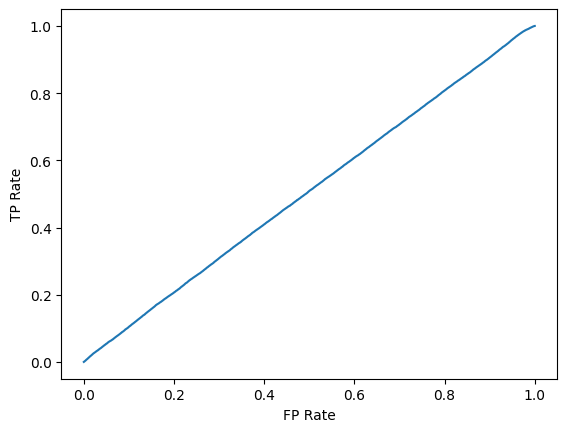

In [17]:
from sklearn.metrics import roc_curve

model_file_path = "dnn_models/log_transformed/pca95_feature27/with_earlystopping001_0425(minmaxscaler).h5"
valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []

# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# KFold validation 사용
# k: n_splits=5
kf = KFold(random_state=30,
           n_splits=5,
           shuffle=True
          )
model = tf.keras.models.load_model(model_file_path)
for train_index, val_index in kf.split(x_train, y_train):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]
    
    pred = model.predict(X_val_fold)
    
    pred_1d = pred.flatten()
    
    pred = np.where(pred_1d > 0.5, 1 , 0)
    Y_val_fold = tf.cast(Y_val_fold, tf.int32)

    valid_acc = accuracy_score(Y_val_fold, pred)
    print(valid_acc)
    valid_accs.append(valid_acc)
    valid_f1 = f1_score(Y_val_fold, pred)
    valid_precision = precision_score(Y_val_fold, pred)
    valid_recall = recall_score(Y_val_fold, pred)
    valid_f1s.append(valid_f1)
    valid_precisions.append(valid_precision)
    valid_recalls.append(valid_recall)
    print("===================================")
    print("Validation(fold) accuracy:", valid_acc)
    print("Validation(fold) F1-score:", valid_f1)
    print("Validation(fold) recall:", valid_recall)
    print("Validation(fold) precision:", valid_precision)
print("###################################")
print("avg Validation(fold) accuracy:", np.mean(valid_accs))
print("avg Validation(fold) F1-score:", np.mean(valid_f1s))
print("avg Validation(fold) recall:", np.mean(valid_recalls))
print("avg Validation(fold) precision:", np.mean(valid_precisions))

valid_pred = model.predict(x_validation)
print(valid_pred)
valid_preds_1d = valid_pred.flatten()
print(valid_preds_1d)
valid_pred = np.where(valid_preds_1d>0.3, 1, 0)
print("###################################")
print("Validation accuracy:", accuracy_score(y_validation, valid_pred))
print("Validation F1-score:", f1_score(y_validation, valid_pred))
print("Validation recall:", recall_score(y_validation, valid_pred))
print("Validation precision:", precision_score(y_validation, valid_pred))
fpr, tpr, thresholds = roc_curve(y_validation, valid_preds_1d)
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

plt.show()

In [13]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    model_with_threshold(threshold)

5659/5659 [==============================] - 4s 595us/step
0.5938675311621536
5659/5659 [==============================] - 3s 606us/step
0.5915700644505686
5659/5659 [==============================] - 4s 627us/step
0.5920671125372096
5659/5659 [==============================] - 3s 600us/step
0.5914430410506492
5659/5659 [==============================] - 3s 594us/step
0.5916418602853056
###################################
avg Validation(fold) accuracy: 0.5921179218971773
avg Validation(fold) F1-score: 0.259370901251446
avg Validation(fold) recall: 0.3534392508471894
avg Validation(fold) precision: 0.20485405723603028
7074/7074 [==============================] - 4s 602us/step
###################################
Validation accuracy: 0.5936590128878619
Validation F1-score: 0.26090520428171915
Validation recall: 0.35492052386470474
Validation precision: 0.2062669157168452
5659/5659 [==============================] - 4s 628us/step
0.6641280395871187
5659/5659 [==============================